In [ ]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from bs4 import BeautifulSoup
from collections import namedtuple

from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, explode, col, monotonically_increasing_id, pandas_udf, when
from pyspark.sql.types import StringType, ArrayType, FloatType, StructType, StructField
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors, VectorUDT
# Use a powerful sentence-transformer model
# 'all-MiniLM-L6-v2' is a great balance of performance and speed.
EMBEDDING_MODEL_NAME = 'all-MiniLM-L6-v2'
EMBEDDING_DIMENSION = 384 # This is specific to the 'all-MiniLM-L6-v2' model
KMEANS_CLUSTERS = 8

In [ ]:
def setup_spark_session():
    """Initializes and returns a SparkSession."""
    return (
        SparkSession.builder
        .appName("SEC_Filings_Analysis")
        .master("local[*]")  # Use all available local cores
        .config("spark.driver.memory", "8g")
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")
        .getOrCreate()
    )

def extract_cik_from_path(path):
    """Extracts the CIK from the file path using regex."""
    match = re.search(r'(\d{10})', path)
    return match.group(1) if match else None

@udf(returnType=StringType())
def clean_html(html_content):
    """Uses BeautifulSoup to parse HTML and extract clean text."""
    if html_content:
        soup = BeautifulSoup(html_content, 'lxml')
        return soup.get_text(separator=' ', strip=True)
    return ""

def extract_and_chunk_sections(text, chunk_size=1000, overlap=100):
    """
    Identifies major 10-K sections and chunks text within each section.
    Returns a list of tuples: (section_name, chunk_text).
    """
    if not text:
        return []

    # Regex to find major item headers. Captures the header itself. This pattern looks for "Item" followed by a number (e.g., 1, 1A, 7, 9B)
    section_pattern = re.compile(r'(Item\s+\d{1,2}[A-Z]?\.)', re.IGNORECASE)

    # Split the document by these headers
    parts = section_pattern.split(text)

    # The first part is pre-header content
    sections = [("Header", parts[0])]

    # Group the rest into (header, content) tuples
    for i in range(1, len(parts), 2):
        section_title = parts[i].strip()
        section_content = parts[i+1] if (i+1) < len(parts) else ""
        sections.append((section_title, section_content))

    # Now, chunk the text within each identified section
    section_chunks = []
    for section_title, section_content in sections:
        if not section_content.strip():
            continue

        start = 0
        while start < len(section_content):
            end = start + chunk_size
            chunk = section_content[start:end]
            section_chunks.append((section_title, chunk))
            start += chunk_size - overlap

    return section_chunks

# Define the schema for the UDF's return type
ChunkSchema = StructType([
    StructField("section", StringType(), False),
    StructField("text_chunk", StringType(), False)
])

@udf(returnType=ArrayType(ChunkSchema))
def section_chunking_udf(text):
    """PySpark UDF to apply the section-aware chunking logic."""
    return extract_and_chunk_sections(text)



def get_embeddings_pandas_udf():
    """
    Returns a Pandas UDF to generate embeddings for text chunks.
    This is highly efficient as the model is loaded only once per worker.
    """
    import pandas as pd
    from sentence_transformers import SentenceTransformer

    # Pandas UDF (vectorized UDF)
    @pandas_udf(ArrayType(FloatType()))
    def get_embeddings(texts: pd.Series) -> pd.Series:
        # The model is loaded once per worker process for a batch of data
        model = SentenceTransformer(EMBEDDING_MODEL_NAME
        embeddings = model.encode(texts.tolist(), show_progress_bar=False)

        # return pandas.Series
        return pd.Series(list(e) for e in embeddings)

    return get_embeddings

def create_and_save_plot(dataframe, hue_col, title, filename):
    """Creates and saves a scatter plot from the results."""
    plt.figure(figsize=(14, 10))

    # Use a categorical palette if the hue column is not numeric
    palette = 'viridis' if pd.api.types.is_numeric_dtype(dataframe[hue_col]) else 'tab20'

    sns.scatterplot(
        data=dataframe,
        x='pca1',
        y='pca2',
        hue=hue_col,
        palette=palette,
        alpha=0.7,
        s=50,
        legend='full'
    )

    plt.title(title, fontsize=16)
    plt.xlabel('Principal Component 1', fontsize=12)
    plt.ylabel('Principal Component 2', fontsize=12)

    # Adjust legend for readability
    if dataframe[hue_col].nunique() > 20:
        plt.legend([],[], frameon=False) # Hide legend if too many categories
        print(f"Note: Legend for '{filename}' hidden due to too many categories ({dataframe[hue_col].nunique()}).")
    else:
        plt.legend(title=hue_col, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(True)
    plt.tight_layout()

    plot_dir = "plots"
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    plot_path = os.path.join(plot_dir, filename)
    plt.savefig(plot_path, format='jpeg', dpi=150)
    print(f"Visualization saved to {plot_path}")

    plt.show()

    plt.close()

In [ ]:
spark = setup_spark_session()

In [ ]:
# --- 1. Data Ingestion ---
data_path = "/content/*.htm"

# Use wholeTextFiles to read each file as a single record (path, content)
raw_files_rdd = spark.sparkContext.wholeTextFiles(data_path)

# Convert to DataFrame and extract CIK
extract_cik_udf = udf(extract_cik_from_path, StringType())
initial_df = raw_files_rdd.toDF(["filepath", "html_content"])
initial_df = initial_df.withColumn("cik", extract_cik_udf(col("filepath")))

print("Step 1: Loaded initial data.")
initial_df.show(5, truncate=False)

In [ ]:
# --- 2. Text Extraction & Chunking ---
# Clean HTML to get raw text
text_df = initial_df.withColumn("text", clean_html(col("html_content")))

# Use the new section-aware chunking UDF
chunked_df = text_df.withColumn("section_chunks", section_chunking_udf(col("text")))



# Explode the structured chunks
docs_df = chunked_df.select("cik", explode("section_chunks").alias("chunk_struct"))
docs_df = docs_df.select(
    "cik",
    col("chunk_struct.section").alias("section"),
    col("chunk_struct.text_chunk").alias("text_chunk")
).withColumn("id", monotonically_increasing_id())

docs_df.cache()
print(f"Step 2: Extracted and chunked text into {docs_df.count()} section-aware chunks.")
docs_df.show(5, truncate=True)



Step 2: Extracted and chunked text into 6106 section-aware chunks.
+----------+-------+--------------------+---+
|       cik|section|          text_chunk| id|
+----------+-------+--------------------+---+
|0001018724| Header|Document 0.5 P1Y ...|  0|
|0001018724| Header|ceMember 2019-01-...|  1|
|0001018724| Header|ngsMember 2017-01...|  2|
|0001018724| Header|01-01 2019-12-31 ...|  3|
|0001018724| Header|1-01 2018-12-31 0...|  4|
+----------+-------+--------------------+---+
only showing top 5 rows



In [ ]:
 # --- 3. Embedding ---
embedding_udf = get_embeddings_pandas_udf()
embedded_df = docs_df.withColumn("embedding", embedding_udf(col("text_chunk")))

print("Step 3: Generated embeddings.")


Step 3: Generated embeddings.


In [ ]:
 # --- 4. ML Pipeline: Scaling, PCA, and KMeans ---
# Convert array to vector for MLlib
vec_udf = udf(lambda r: Vectors.dense(r), VectorUDT())
vectorized_df = embedded_df.withColumn("embedding_vec", vec_udf(col("embedding")))

# Define pipeline stages
scaler = StandardScaler(inputCol="embedding_vec", outputCol="scaled_embedding", withStd=True, withMean=True)
pca = PCA(k=2, inputCol="scaled_embedding", outputCol="pca_features")
kmeans = KMeans(featuresCol="pca_features", k=KMEANS_CLUSTERS, seed=1, predictionCol="cluster_id")

# Create and run the pipeline
pipeline = Pipeline(stages=[scaler, pca, kmeans])
pipeline_model = pipeline.fit(vectorized_df)
processed_df = pipeline_model.transform(vectorized_df)

print("Step 4: Executed ML pipeline (Scaling, PCA, KMeans).")
processed_df.select("cik", "section", "cluster_id").show(5, truncate=True)

Step 4: Executed ML pipeline (Scaling, PCA, KMeans).
+----------+-------+----------+
|       cik|section|cluster_id|
+----------+-------+----------+
|0001018724| Header|         3|
|0001018724| Header|         1|
|0001018724| Header|         1|
|0001018724| Header|         1|
|0001018724| Header|         1|
+----------+-------+----------+
only showing top 5 rows



In [ ]:
# --- 5. Create Outlier Flag ---
# method (1)  - Identify the smallest cluster(s) as outliers
cluster_sizes = processed_df.groupBy("cluster_id").count().orderBy("count")
print("\nCluster sizes:")
cluster_sizes.show()

# Get the size of the smallest cluster
smallest_cluster_size = cluster_sizes.first()["count"]

# Find all clusters with that minimal size
outlier_cluster_ids = [row.cluster_id for row in cluster_sizes.filter(col("count") == smallest_cluster_size).collect()]

# Create the outlier flag column
final_df = processed_df.withColumn("outlier_flag", when(col("cluster_id").isin(outlier_cluster_ids), 1).otherwise(0))

print(f"Step 5: Identified clusters {outlier_cluster_ids} as outliers.")
final_df.select("id", "cluster_id", "outlier_flag").show(5)


Cluster sizes:
+----------+-----+
|cluster_id|count|
+----------+-----+
|         2|  461|
|         6|  507|
|         3|  690|
|         5|  746|
|         4|  776|
|         1|  777|
|         0|  956|
|         7| 1193|
+----------+-----+

Step 5: Identified clusters [2] as outliers.
+---+----------+------------+
| id|cluster_id|outlier_flag|
+---+----------+------------+
|  0|         3|           0|
|  1|         1|           0|
|  2|         1|           0|
|  3|         1|           0|
|  4|         1|           0|
+---+----------+------------+
only showing top 5 rows




Step 6: Generating plots...
Visualization saved to plots/plot_by_cik.jpeg


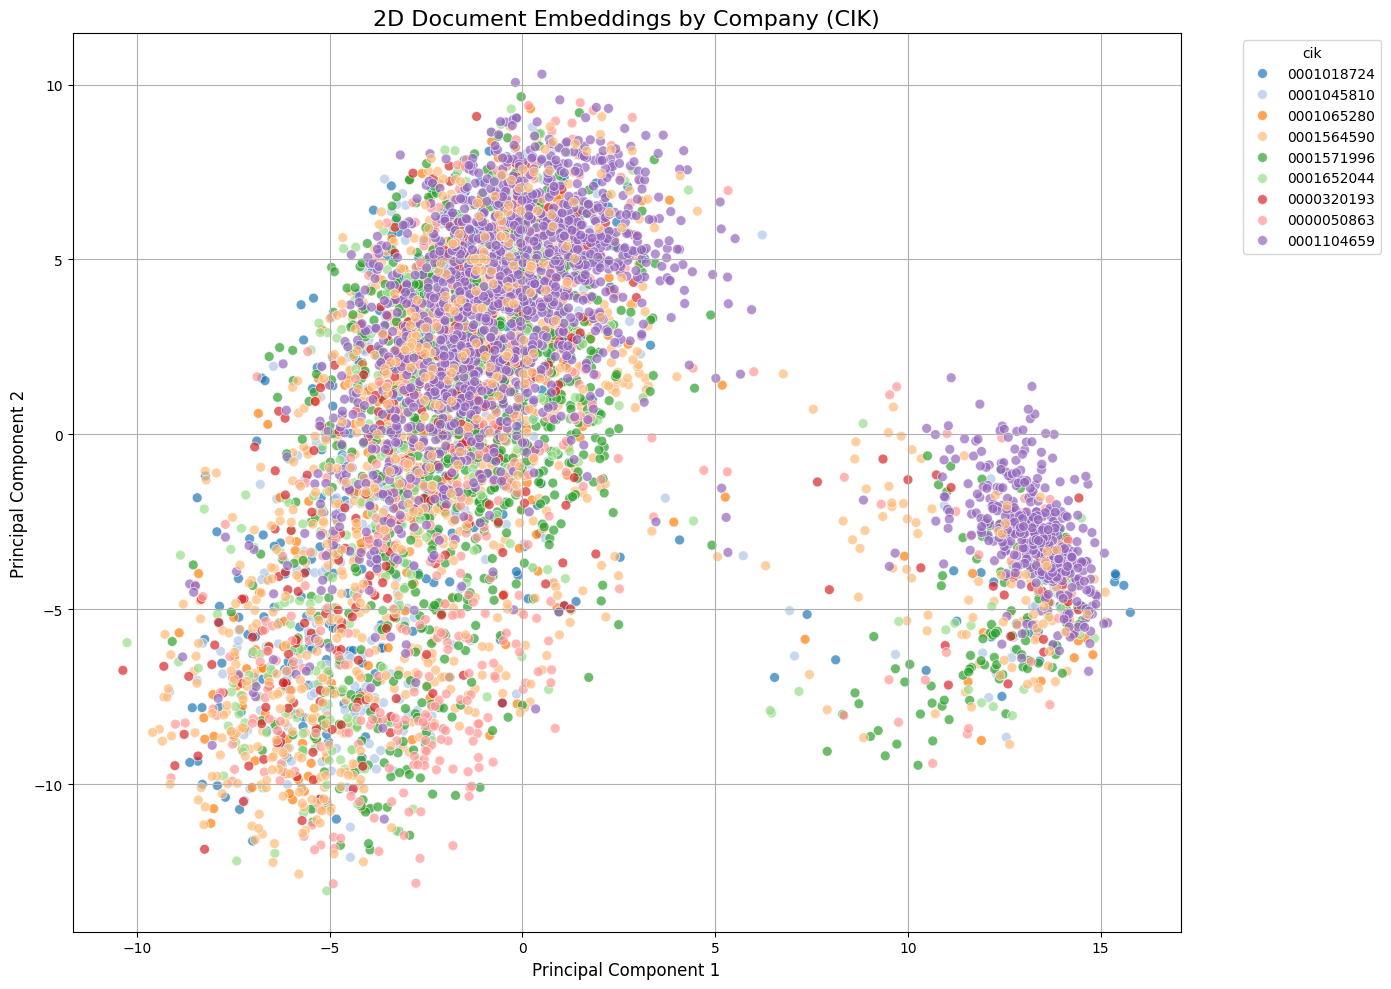

Visualization saved to plots/plot_by_cluster.jpeg


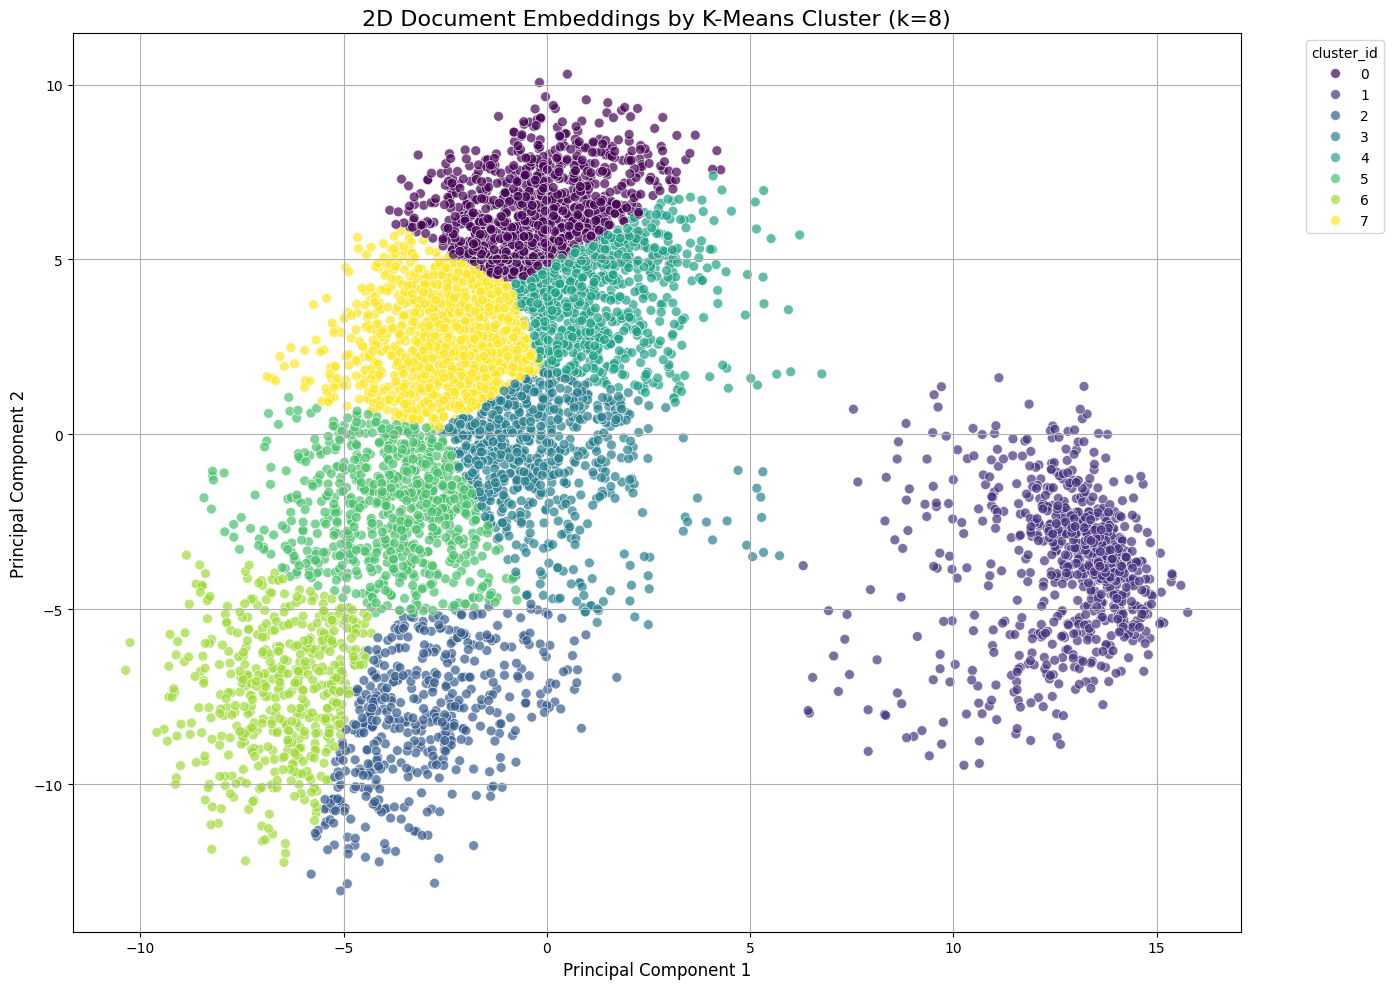

Visualization saved to plots/plot_by_outlier.jpeg


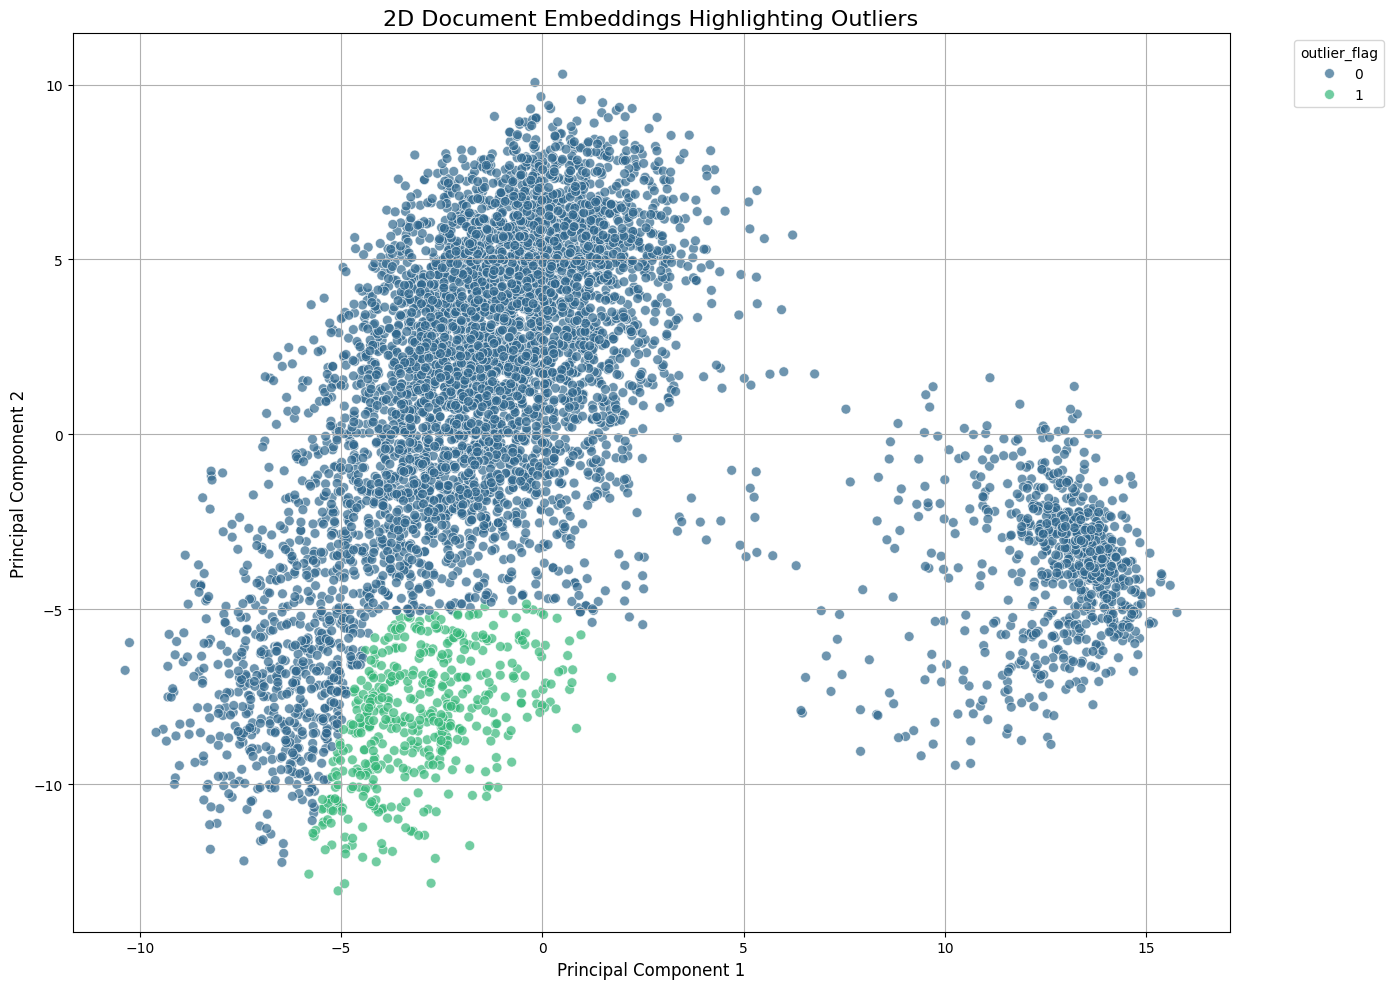

Visualization saved to plots/plot_by_section.jpeg


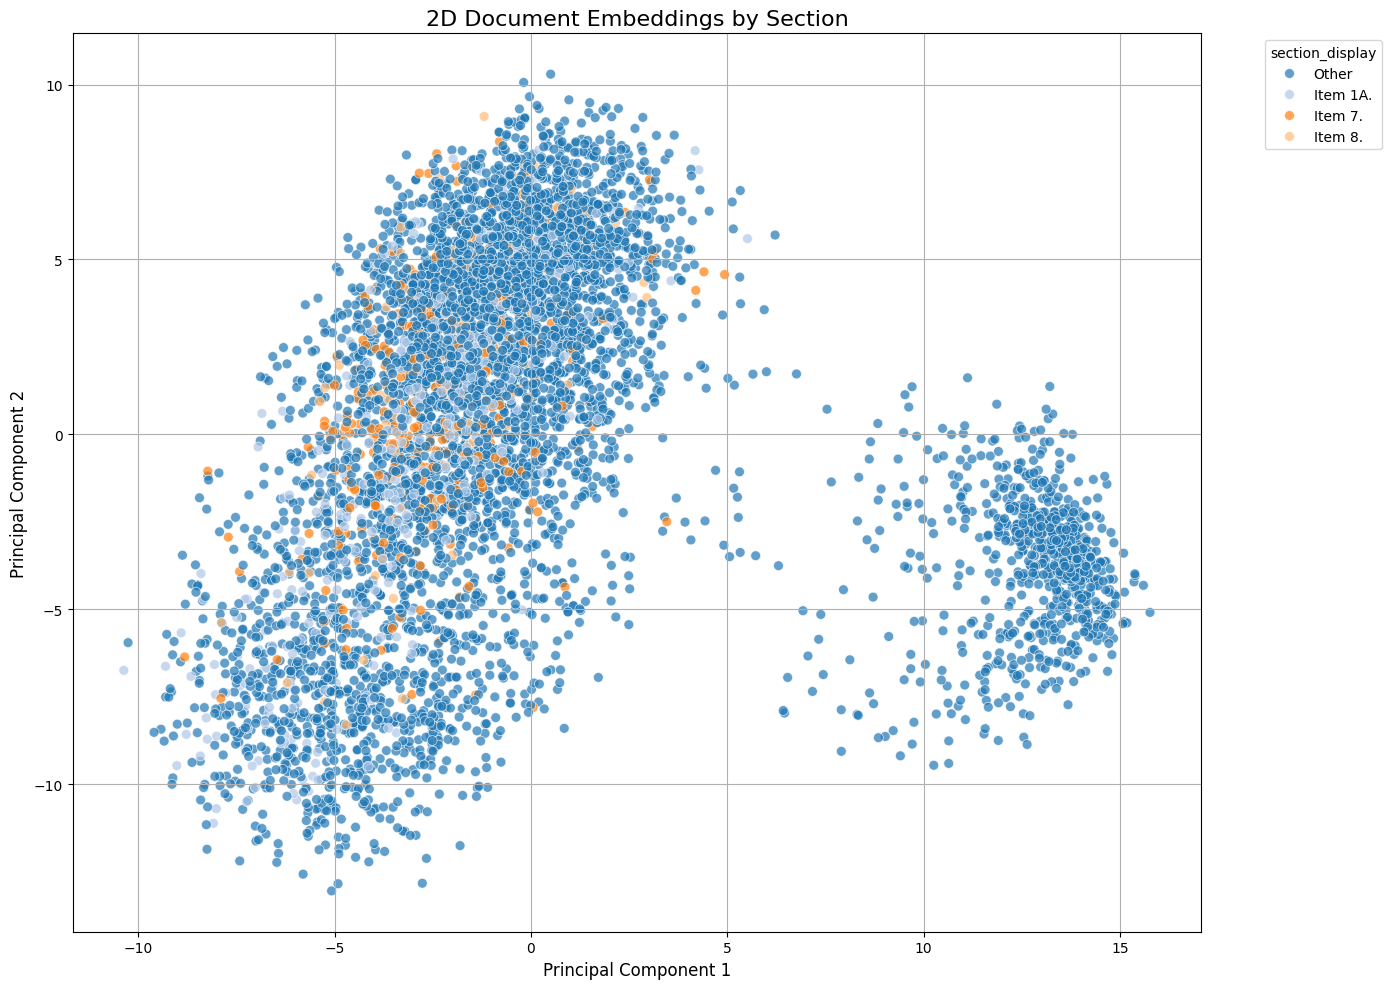


--- Outlier Inspection ---
Inspecting an outlier chunk (ID: 37) from CIK: 0001018724
Cluster: 2, Section: Item 1.

Outlier Chunk Text:
--------------------
 Business 3 
--------------------


In [ ]:
# --- 6. Visualization ---
# Collect data for plotting
results_pd = final_df.select("id", "cik", "section", "pca_features", "cluster_id", "outlier_flag", "text_chunk").toPandas()

# Extract PCA components into separate columns
results_pd['pca1'] = results_pd['pca_features'].apply(lambda v: float(v[0]))
results_pd['pca2'] = results_pd['pca_features'].apply(lambda v: float(v[1]))

print("\nStep 6: Generating plots...")

# Plot 1: Colored by Company CIK
create_and_save_plot(results_pd, 'cik', '2D Document Embeddings by Company (CIK)', 'plot_by_cik.jpeg')

# Plot 2: Colored by Assigned Cluster
create_and_save_plot(results_pd, 'cluster_id', f'2D Document Embeddings by K-Means Cluster (k={KMEANS_CLUSTERS})', 'plot_by_cluster.jpeg')

# Plot 3: Colored by Outlier Flag
create_and_save_plot(results_pd, 'outlier_flag', '2D Document Embeddings Highlighting Outliers', 'plot_by_outlier.jpeg')

# Plot 4: Colored by Section
key_sections = ["Item 1A.", "Item 7.", "Item 8."]
results_pd['section_display'] = results_pd['section'].apply(lambda s: s if s in key_sections else 'Other')
create_and_save_plot(results_pd, 'section_display', '2D Document Embeddings by Section', 'plot_by_section.jpeg')

# Inspect an outlier chunk
outlier_chunk = results_pd[results_pd['outlier_flag'] == 1].iloc[0]
print("\n--- Outlier Inspection ---")
print(f"Inspecting an outlier chunk (ID: {outlier_chunk['id']}) from CIK: {outlier_chunk['cik']}")
print(f"Cluster: {outlier_chunk['cluster_id']}, Section: {outlier_chunk['section']}")
print("\nOutlier Chunk Text:")
print("-" * 20)
print(outlier_chunk['text_chunk'])
print("-" * 20)


In [ ]:
# Method 2 max distance cluster - NEW OUTLIER DETECTION LOGIC ---
import numpy as np

OUTLIER_PERCENTILE_THRESHOLD = 0.95 # Flag top 1% of most distant points as outliers

print("\nStep 5: Performing Outlier Detection...")

# Get the cluster centers from the trained KMeans model
centers = pipeline_model.stages[-1].clusterCenters()

# UDF to calculate the distance from a point to its assigned cluster center
@udf(FloatType())
def distance_to_center(features, cluster_id):
    center = centers[cluster_id]
    # Using numpy for efficient vector operations (Euclidean distance)
    return float(np.linalg.norm(np.array(features) - np.array(center)))

# Calculate the distance for each point
distance_df = processed_df.withColumn(
    "distance_to_center",
    distance_to_center(col("pca_features"), col("cluster_id"))
)

# Determine the distance threshold using an approximate percentile
# This is a robust way to find the top N% of outliers
outlier_threshold = distance_df.stat.approxQuantile(
    "distance_to_center", [OUTLIER_PERCENTILE_THRESHOLD], 0.05
)[0]

print(f"Calculated outlier distance threshold: {outlier_threshold:.4f} (95th percentile)")

# Create the final outlier flag
final_df = distance_df.withColumn(
    "outlier_flag",
    when(col("distance_to_center") >= outlier_threshold, 1).otherwise(0)
)

print("Outlier detection complete.")
final_df.groupBy("outlier_flag").count().show()


Step 5: Performing Outlier Detection...
Calculated outlier distance threshold: 7.5592 (95th percentile)
Outlier detection complete.
+------------+-----+
|outlier_flag|count|
+------------+-----+
|           1|    1|
|           0| 6105|
+------------+-----+




Step 6: Generating plots...
Visualization saved to plots/plot_by_cik.jpeg


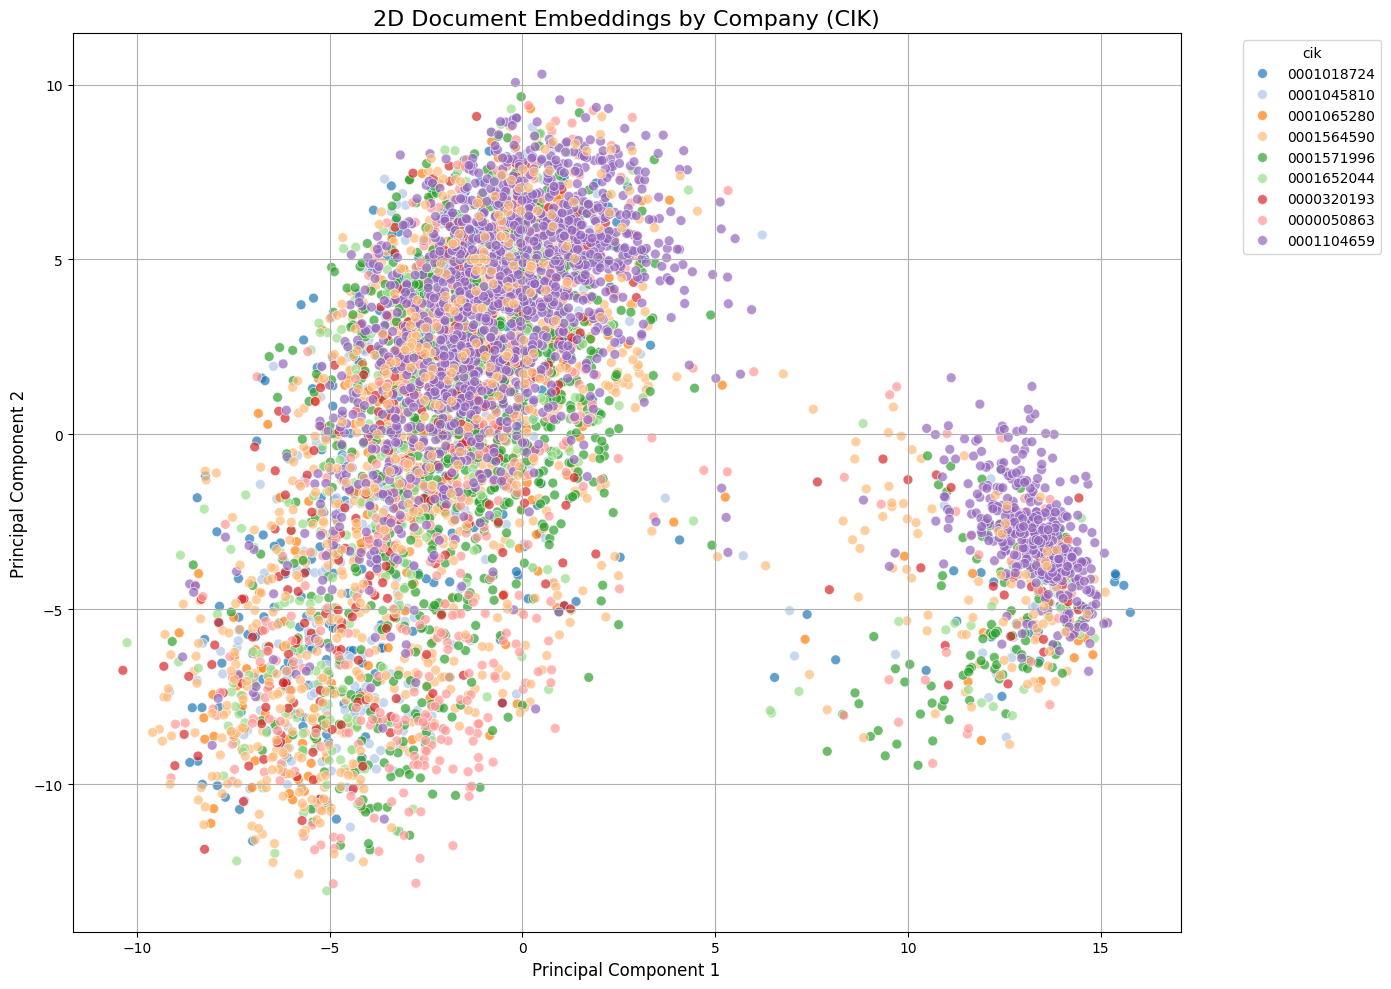

Visualization saved to plots/plot_by_cluster.jpeg


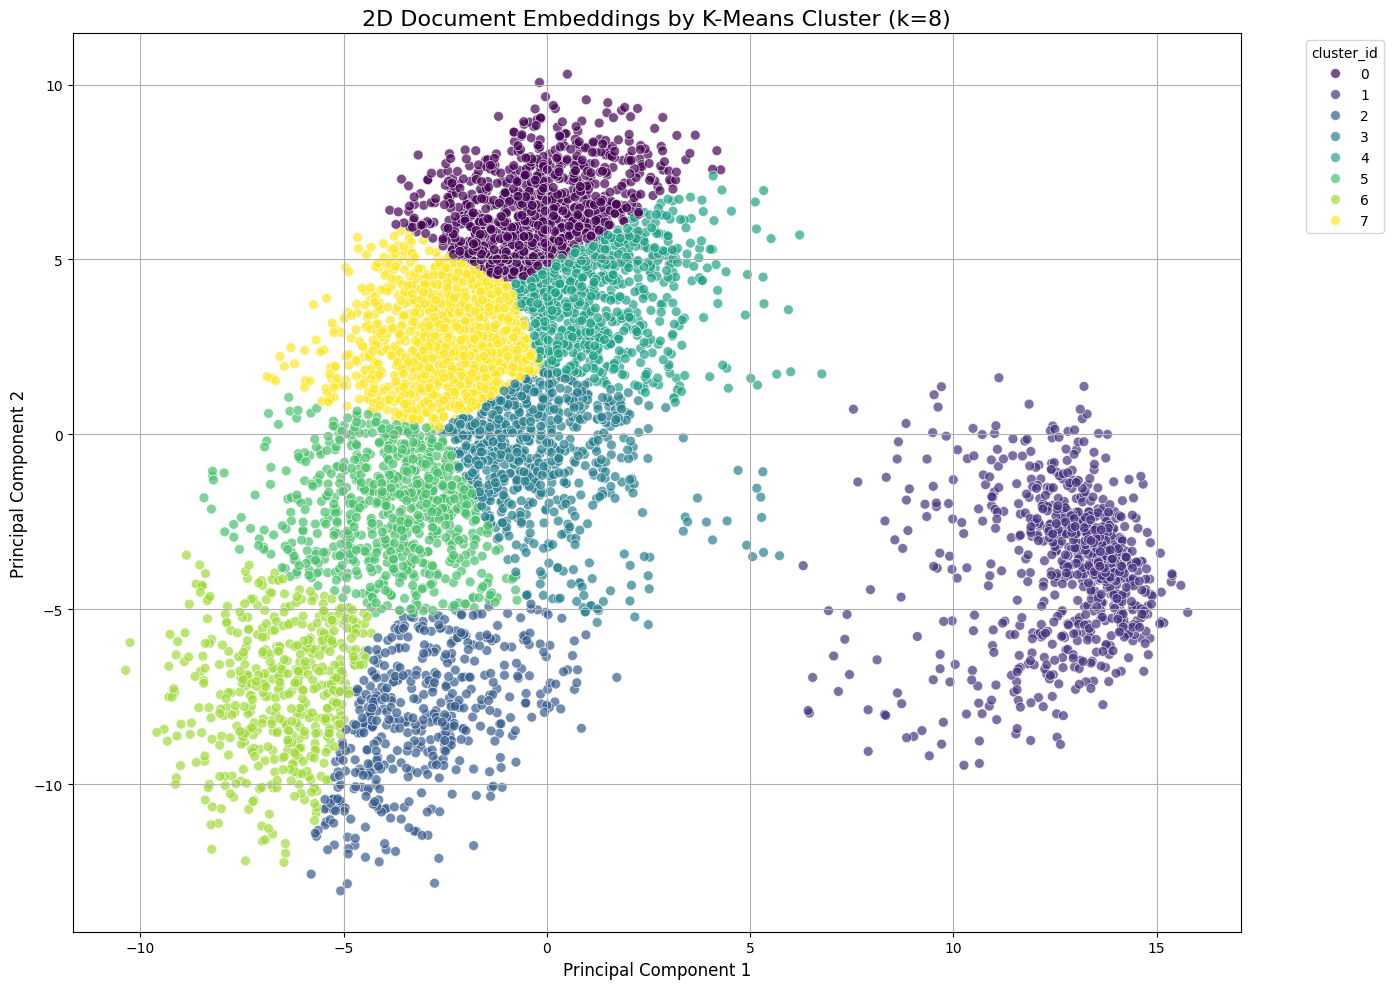

Visualization saved to plots/plot_by_outlier.jpeg


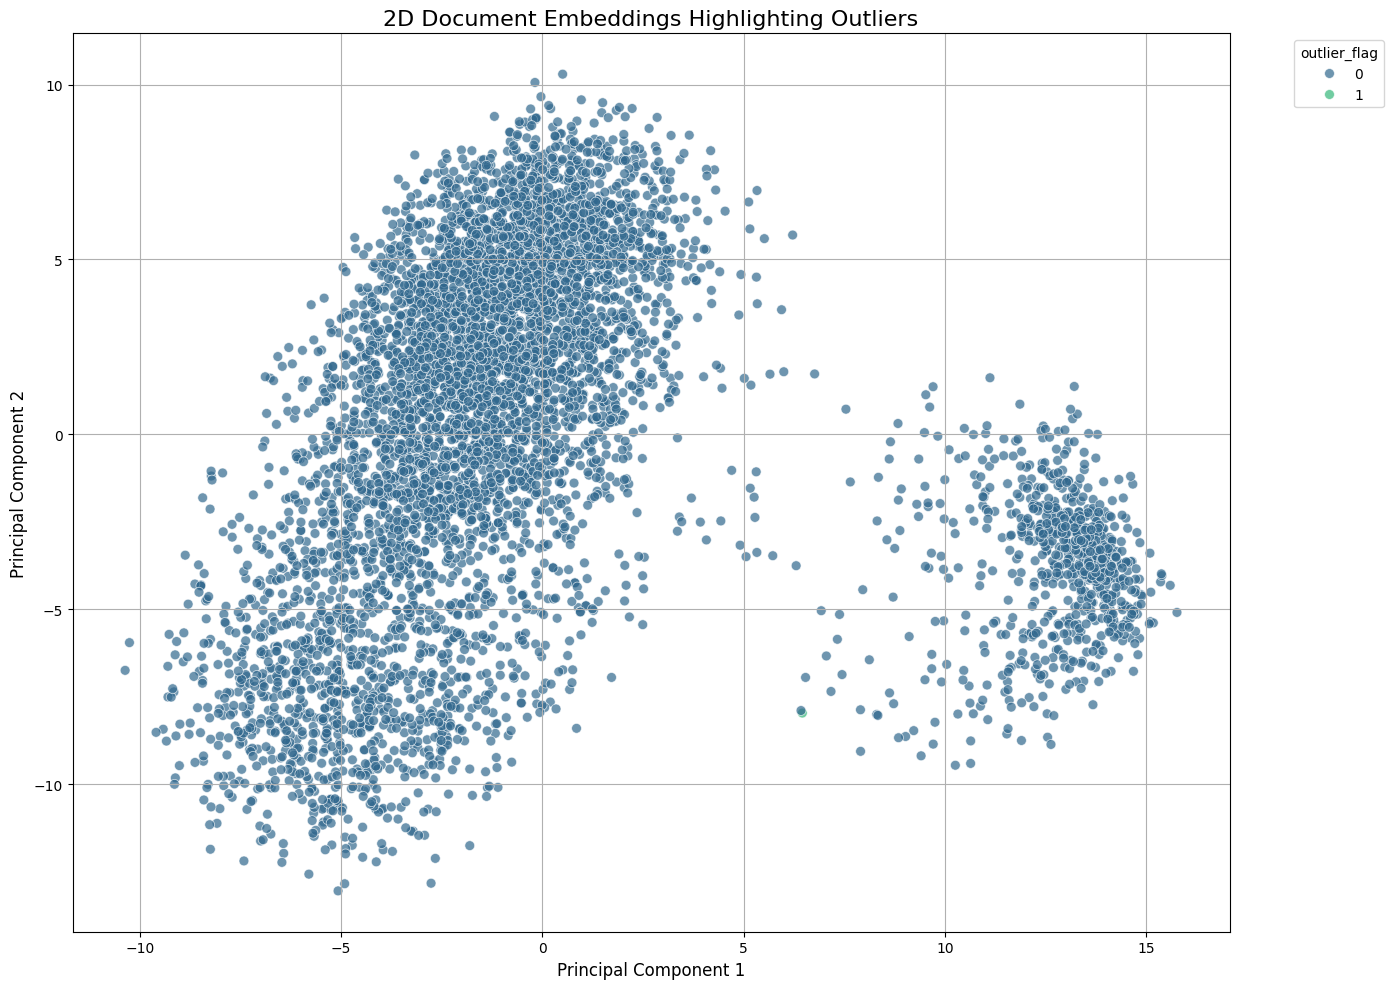

Visualization saved to plots/plot_by_section.jpeg


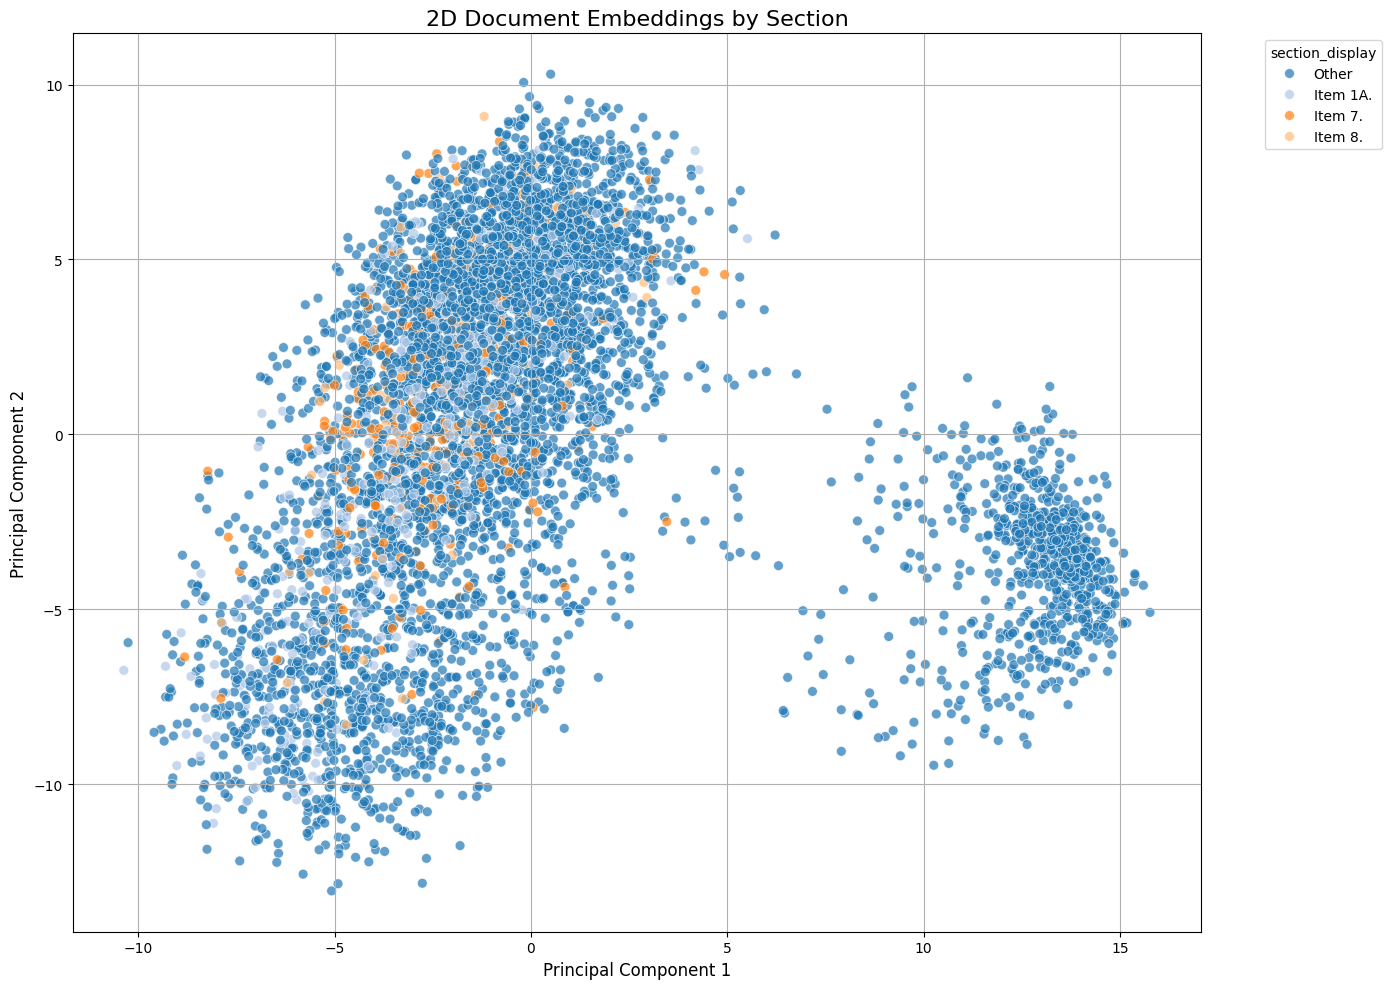


--- Outlier Inspection ---
Inspecting an outlier chunk (ID: 2560) from CIK: 0001652044
Cluster: 1, Section: Header

Outlier Chunk Text:
--------------------
icConcentrationRiskMember 2019-01-01 2019-12-31 0001652044 goog:AmericasExcludingUnitedStatesMember 2018-01-01 2018-12-31 0001652044 us-gaap:SalesRevenueNetMember us-gaap:GeographicConcentrationRiskMember 2019-01-01 2019-12-31 0001652044 goog:YouTubeAdvertisingRevenueMember goog:GoogleInc.Member 2018-01-01 2018-12-31 0001652044 goog:OtherRevenuesMember goog:GoogleInc.Member 2018-01-01 2018-12-31 0001652044 goog:GooglePropertiesMember goog:GoogleInc.Member 2017-01-01 2017-12-31 0001652044 goog:GoogleSearchOtherMember goog:GoogleInc.Member 2018-01-01 2018-12-31 0001652044 goog:GoogleAdvertisingRevenueMember goog:GoogleInc.Member 2019-01-01 2019-12-31 0001652044 goog:GoogleNetworkMembersPropertiesMember goog:GoogleInc.Member 2017-01-01 2017-12-31 0001652044 goog:GoogleAdvertisingRevenueMember goog:GoogleInc.Member 2017-01-01 2017-12-

In [ ]:
# --- 6. Visualization ---
# Collect data for plotting
results_pd = final_df.select("id", "cik", "section", "pca_features", "cluster_id", "outlier_flag", "text_chunk").toPandas()

# Extract PCA components into separate columns
results_pd['pca1'] = results_pd['pca_features'].apply(lambda v: float(v[0]))
results_pd['pca2'] = results_pd['pca_features'].apply(lambda v: float(v[1]))

print("\nStep 6: Generating plots...")

# Plot 1: Colored by Company CIK
create_and_save_plot(results_pd, 'cik', '2D Document Embeddings by Company (CIK)', 'plot_by_cik.jpeg')

# Plot 2: Colored by Assigned Cluster
create_and_save_plot(results_pd, 'cluster_id', f'2D Document Embeddings by K-Means Cluster (k={KMEANS_CLUSTERS})', 'plot_by_cluster.jpeg')

# Plot 3: Colored by Outlier Flag
create_and_save_plot(results_pd, 'outlier_flag', '2D Document Embeddings Highlighting Outliers', 'plot_by_outlier.jpeg')

# Plot 4: Colored by Section
key_sections = ["Item 1A.", "Item 7.", "Item 8."]
results_pd['section_display'] = results_pd['section'].apply(lambda s: s if s in key_sections else 'Other')
create_and_save_plot(results_pd, 'section_display', '2D Document Embeddings by Section', 'plot_by_section.jpeg')

# Inspect an outlier chunk
outlier_chunk = results_pd[results_pd['outlier_flag'] == 1].iloc[0]
print("\n--- Outlier Inspection ---")
print(f"Inspecting an outlier chunk (ID: {outlier_chunk['id']}) from CIK: {outlier_chunk['cik']}")
print(f"Cluster: {outlier_chunk['cluster_id']}, Section: {outlier_chunk['section']}")
print("\nOutlier Chunk Text:")
print("-" * 20)
print(outlier_chunk['text_chunk'])
print("-" * 20)


In [ ]:
#spark.stop()